In [2]:
import numpy as np
import matplotlib.pyplot as plt  # To visualize
import pandas as pd  # To read data
from sklearn.linear_model import LinearRegression, BayesianRidge
import statsmodels.api as sm

In [3]:
data_dir = '../../data/'

In [4]:
# Read the data and parse the PROF_DATE_TIME_LOCAL column to a datetime object
data = pd.read_csv(data_dir + 'concat/MWRA_TA_DIC_2017_to_2022.csv'
                   , parse_dates=['PROF_DATE_TIME_LOCAL'])
sal_and_ta = data[(data['SAL (PSU)'].notnull()) & (data['pH ()'].notnull()) & (data['TEMP (C)'].notnull())]

In [6]:
# Prediction
SAL = sal_and_ta['SAL (PSU)'].values.reshape(-1, 1)
TEMP = sal_and_ta['TEMP (C)'].values.reshape(-1, 1)
X = np.concatenate((SAL, TEMP), axis=1)
Y = sal_and_ta['pH ()'].values.reshape(-1, 1)
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions

# Calculate RMSE
sm.add_constant(X)
mlr = sm.OLS(Y, X).fit()
R = float(np.sqrt(mlr.mse_resid))
twoR = 2 * R

yPlus2R = Y_pred + twoR
yMinus2R = Y_pred - twoR

In [7]:
# Find and remove the outliers
sal_and_ta_no_outliers = sal_and_ta.copy()
outliers = pd.DataFrame(columns = sal_and_ta.columns)
for ind, row in sal_and_ta.iterrows():
  predicted_ph = float(linear_regressor.predict([[row['SAL (PSU)'], row['TEMP (C)']]]))
  actual_ph = float(row['pH ()'])
  if abs(predicted_ph - actual_ph) > twoR:
    sal_and_ta_no_outliers.drop(ind, inplace=True) # drop the row with the outlier
    outliers.loc[len(outliers.index)] = row

In [7]:
#outliers.to_csv('outliers.csv')

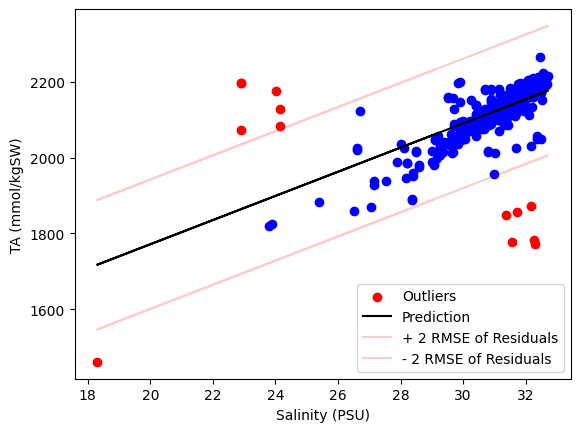

In [8]:
# Plot the non-outliers and the outliers
plt.scatter(sal_and_ta_no_outliers['SAL (PSU)'], sal_and_ta_no_outliers['TA in (mmol/kgSW)'], color='blue')
plt.scatter(outliers['SAL (PSU)'], outliers['TA in (mmol/kgSW)'], color='red', label='Outliers')
plt.plot(X, Y_pred, color='black', label='Prediction')
plt.plot(X, yPlus2R, color = 'red', alpha = 0.2, label = '+ 2 RMSE of Residuals')
plt.plot(X, yMinus2R, color = 'red', alpha = 0.2, label = '- 2 RMSE of Residuals')
plt.xlabel('Salinity (PSU)')
plt.ylabel('TA (mmol/kgSW)')
plt.legend()
plt.show()

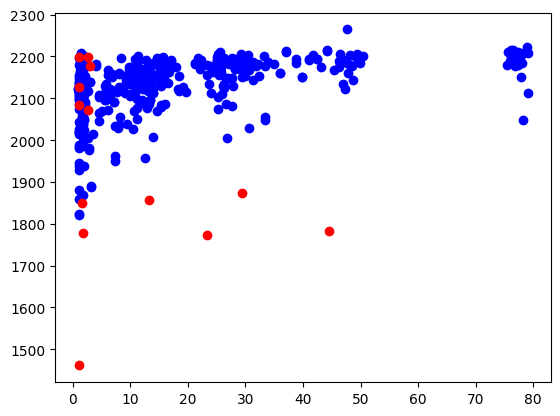

In [9]:
# Plot the depths of the outliers and the non-outliers
plt.scatter(sal_and_ta_no_outliers['DEPTH (m)'], sal_and_ta_no_outliers['TA in (mmol/kgSW)'], color='blue')
plt.scatter(outliers['DEPTH (m)'], outliers['TA in (mmol/kgSW)'], color='red', label='Outliers')

In [21]:
outliers = outliers[outliers['DEPTH (m)'] > 1.1]

In [8]:
# Bayesian Ridge Regression
X1 = sal_and_ta_no_outliers['SAL (PSU)'].values.reshape(-1, 1)
X2 = sal_and_ta_no_outliers['TEMP (C)'].values.reshape(-1, 1)
X = np.concatenate((X1, X2), axis=1)
Y = sal_and_ta_no_outliers['pH ()'].values.reshape(-1, 1)
bayesian_regressor = BayesianRidge()
bayesian_regressor.fit(X, Y)
Y_pred = bayesian_regressor.predict(X)

/Users/becklabash/Library/Python/3.8/lib/python/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [11]:
sal_and_ta_no_outliers['TEMP (C)'].min()

1.622

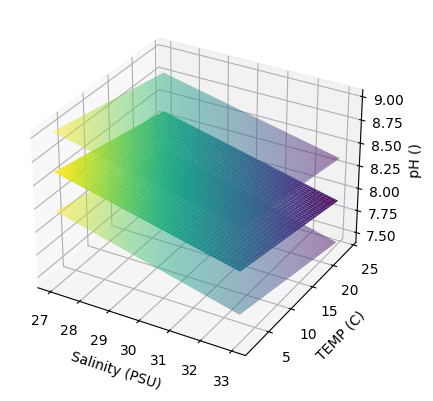

In [17]:
# Visualize the predictions with a mesh and the uncertainty as a second mesh
x1 = np.linspace(27, 33, 100)
x2 = np.linspace(1.622, 24, 100)
X1, X2 = np.meshgrid(x1, x2)
X = np.concatenate((X1.reshape(-1, 1), X2.reshape(-1, 1)), axis=1)


Y_pred, Y_std = bayesian_regressor.predict(X, return_std=True)

Y_pred = Y_pred.reshape(100, 100)


Y_std = Y_std.reshape(100, 100)

# Add and subtract 2 standard deviations to the predictions
Y_plus_2_std = Y_pred + 2 * Y_std
Y_minus_2_std = Y_pred - 2 * Y_std

fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X1, X2, Y_pred, cmap='viridis', edgecolor='none')

ax.plot_surface(X1, X2, Y_plus_2_std, cmap='viridis', edgecolor='none', alpha=0.5)

ax.plot_surface(X1, X2, Y_minus_2_std, cmap='viridis', edgecolor='none',  alpha=0.5)

ax.set_xlabel('Salinity (PSU)')

ax.set_ylabel('TEMP (C)')
ax.set_zlabel('pH ()')
plt.show()

In [23]:
# Use depth and salinity to predict TA
# Create a new dataframe with only the columns we need
sal_and_depth = sal_and_ta[['SAL (PSU)', 'DEPTH (m)']]
sal_and_depth['TA in (mmol/kgSW)'] = Y_pred


X = sal_and_ta[['SAL (PSU)', 'DEPTH (m)']].values
Y = sal_and_ta['TA in (mmol/kgSW)'].values
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions

# Plot the data and the regression
plt.scatter(sal_and_ta['SAL (PSU)'], sal_and_ta['TA in (mmol/kgSW)'], color='blue', label='Actual')
plt.plot(sal_and_ta['SAL (PSU)'], Y_pred, color='red', label='Predicted')
plt.xlabel('Salinity (PSU)')
plt.ylabel('TA (mmol/kgSW)')
plt.legend()

ValueError: Length of values (482) does not match length of index (469)